# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

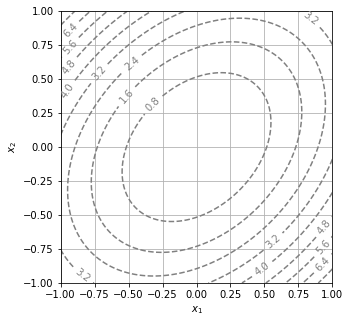

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

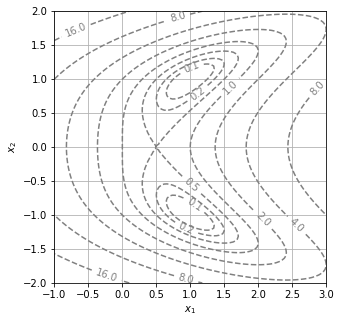

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

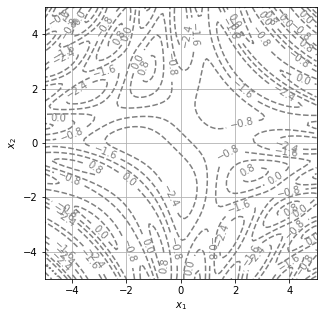

In [163]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 1000
eps = 0.01

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
   """in : une fonction, un point, une précision, un nombre de tentatives
   do : recherche un zéro de la fonction
   out : un point """
   J_F = J(F)
   for i in range(N):
     Jinv = np.linalg.inv(J_F(x0,y0))
     I = np.dot(Jinv,F(x0,y0))
     x = x0 - I[0]
     y = y0 - I[1]
     #X = X0 - np.dot(np.linalg.inv(J_F(X0[0],X0[1])),F(X[0],X[1])) 
#applique la formule d'itération de Newton
     if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
       return x, y
     x0, y0 = x, y
   else:
       raise ValueError(f"no convergence in {N} steps.")


def finte(x,y):
   x = np.array(x)
   y = np.array(y)
   #définition d'une contrainte x = y
   return np.array([f1(x,y),x - y])


In [15]:
Newton(finte,0.8,0.8)

(0.00625, 0.00625)

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [67]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    
    c=f(x0,y0)
    points=[(x0,y0)]
    
    cpt = 0 
    
    
    while True :

        def finte(x,y):
            x = np.array(x)
            y = np.array(y)
            return np.array([f(x,y)-c,(x-x0)**2+(y-y0)**2-delta**2])

        gradient = grad(f)(x0,y0)
        grad0 , grad1 , norme = gradient[0] , gradient[1] , np.linalg.norm(gradient)
        orthgrad0 , orthgrad1 = -grad1/(norme) , grad0/(norme) 
        #vecteur normalisé orthogonal au gradient

        x1,y1=Newton(finte,x0+orthgrad0*eps,y0+orthgrad1*eps) 
        #on se décale du point de départ dans la direction orthogonale 
        #au gradient pour éviter le 0 dans la matrice  et être du bon côté   

        points.append((x1,y1))
        x0,y0=x1,y1

        cpt += 1 
        
        if isincircle(points[0][0],points[0][1], x0, y0, 0.9*delta) :
            break         
    
    return np.array(points)

In [105]:
liste = level_curve(f2, 0.8, 0.8, delta=0.001, N=1000, eps=eps)

In [17]:
def isincircle(x,y,xc,yc,r):
    return (x-xc)**2 + (y-yc)**2 <= r**2

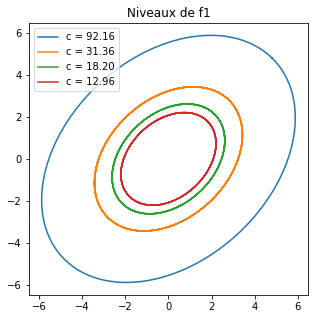

In [196]:
for i in range(1,5): 
    liste = level_curve(f1, 0.8*(i+5)/i, 0.8*(i+5)/i, delta=0.001, N=2000, eps=eps)
    plt.plot(liste[:,0],liste[:,1], label = f'c = {f1(0.8*(i+5)/i, 0.8*(i+5)/i):.2f}') #demander comment tronquer
    #plt.axis('equal')
    plt.title('Niveaux de f1')
    plt.grid()
    plt.legend()

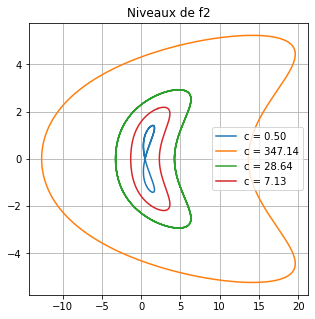

In [197]:
plt.figure()
liste2 = level_curve(f2, 1.5, 1. , delta=0.001, N=5000, eps=eps)
plt.plot(liste2[:,0],liste2[:,1], label = f'c = {f2(1.5,1.):.2f}')
for i in range(1,4): 
    liste = level_curve(f2, 0.8*(i+5)/i, 0.8*(i+5)/i, delta=0.001, N=2000, eps=eps)
    plt.plot(liste[:,0],liste[:,1], label = f'c = {f2(0.8*(i+5)/i, 0.8*(i+5)/i):.2f}')
    #plt.axis('equal')
plt.title('Niveaux de f2')
plt.grid()
plt.legend()


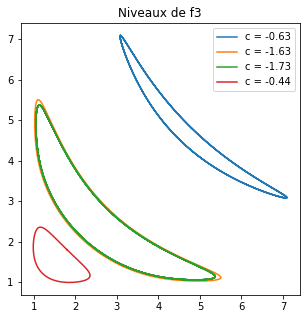

In [198]:
for i in range(1,5): 
    liste = level_curve(f3, 0.8*(i+5)/i, 0.8*(i+5)/i, delta=0.001, N=2000, eps=eps)
    plt.plot(liste[:,0],liste[:,1], label = f'c = {f3(0.8*(i+5)/i, 0.8*(i+5)/i):.2f}')
    #plt.axis('equal')
    plt.title('Niveaux de f3')
    plt.grid()
    plt.legend()

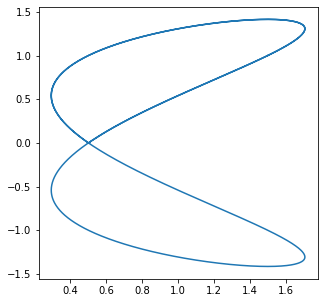

In [38]:
liste = level_curve(f2, 1.5, 1. , delta=0.001, N=5000, eps=eps)
plt.plot(liste[:,0],liste[:,1])

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [188]:
def area_squares(f,c,h):
    
    # retrouver x0, y0 pour appliquer level curve
    def finte(x,y):
       x = np.array(x)
       y = np.array(y)
       #définition d'une contrainte x = y
       return np.array([f(x,y)-c,x - y])
    x0,y0 = Newton(finte, 0.1, 0.1)
    
    plt.figure()
    liste = np.array(level_curve(f, x0, y0, delta=0.01, N=2000, eps=eps ))
    #plt.plot(liste[:,0],liste[:,1])
    
    # quadrillage : 
    
    xmax, xmin, ymax, ymin = np.max(liste[:,0]),np.min(liste[:,0]),np.max(liste[:,1]),np.min(liste[:,1])
    itx, ity = [xmin+ h/2 +i*h for i in range(int((xmax-xmin)/h)+1)] , [ymin + h/2 + i*h for i in range(int((ymax-ymin)/h)+1)]
    
    cpt = 0 
    
    for x in itx :
        for y in ity : 
            if f(x,y)<= c : 
                cpt += 1
                #plt.plot(x,y,'rx')
    
    plt.show()
    return (h**2)*cpt
                                                

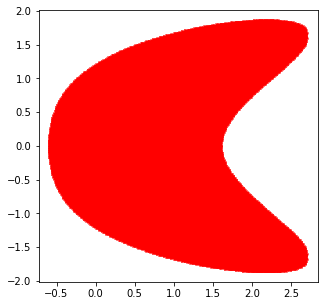

7.729500000000001

In [72]:
area_squares(f2,2.8,0.01)

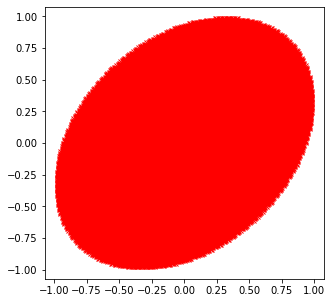

2.8446000000000002

In [71]:
area_squares(f1,2.56,0.01)

In [ ]:
#On définit ici la fonction pour obtenir des cercles de rayon souhaité 

In [97]:
def f4(x,y):
    return x**2 + y**2

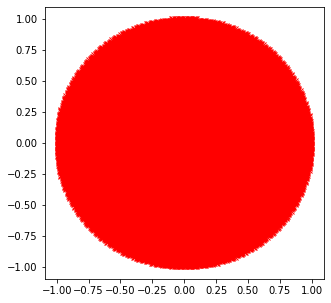

3.1429

In [76]:
area_squares(f4,1,0.01)

In [182]:
#Etude numérique de l'erreur : 
        
def traceErreur(aire,f,N):
    resul = []
    for i in range(N):
        resul.append(aire(f, 1, 10 ** -i))
    resul = np.array(resul)
    resul = np.abs(resul - np.pi)
    H = np.array([10 ** -i for i in range(N)])
    plt.loglog(H, resul)
    print(H, resul)
    plt.show()


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

[1.    0.1   0.01  0.001] [8.58407346e-01 1.84073464e-02 1.20734641e-03 6.13464102e-05]


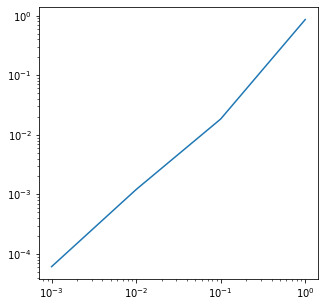

In [189]:
traceErreur(area_squares,f4,4)

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [115]:
# Ceci est la 1ère version, en essayant à la main
#de trouver notre point P dans l'espace convexe et en conservant en argument f et c 
def area_triangles(f,c,delta):
    # retrouver x0, y0 initial sur la frontière pour appliquer level curve
    def finte(x,y):
       x = np.array(x)
       y = np.array(y)
       #définition d'une contrainte x = y
       return np.array([f(x,y)-c,x - y])
    x0,y0 = Newton(finte, 0.1, 0.1)
    
    plt.figure()
    liste = np.array(level_curve(f, x0, y0, delta=delta, N=2000, eps=eps ))
    
    area = 0
    
    #on calcule le point P à l'intérieur de notre espace grâce au gradient 
    gradient = grad(f)(x0,y0)
    grad0 , grad1 , norme = gradient[0] , gradient[1] , np.linalg.norm(gradient)
    orthgrad0 , orthgrad1 = -grad1/(norme) , grad0/(norme)
    P = (x0 +  orthgrad0*delta, y0 + orthgrad1*delta)

    def a_triangle(P,Z1,Z2):
        return np.linalg.det(np.array([Z1-P,Z2-P]))/2
    
    for i in range(len(liste)-1) : 
        Z1,Z2 = liste[i],liste[i+1]
        area += a_triangle(P,Z1,Z2)
    
    return area
        

In [89]:
area_triangles(f4,1,0.01)

3.1415402390569183

<Figure size 360x360 with 0 Axes>

[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04] [5.43516121e-01 5.12578525e-03 5.22010349e-05 1.25666895e+01
 6.91165468e+01]


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

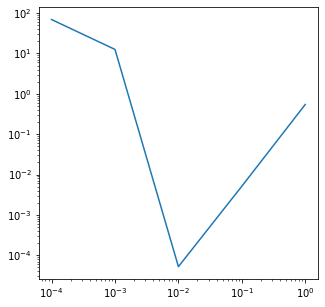

In [190]:
traceErreur(area_triangles,f4,5)

In [185]:
#existence d'un delta limite pour à partir duquel l'erreur explose

In [ ]:
#comportement décroissant logarithmique pour [10^-2; 1] 

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [ ]:

def area_triangles2(f,c,delta):
    # retrouver x0, y0 initial sur la frontière pour appliquer level curve
    def finte(x,y):
       x = np.array(x)
       y = np.array(y)
       #définition d'une contrainte x = y
       return np.array([f(x,y)-c,x - y])
    x0,y0 = Newton(finte, 0.1, 0.1)
    
    plt.figure()
    liste = np.array(level_curve(f, x0, y0, delta=delta, N=2000, eps=eps ))
    
    area = 0
    
    P = (0,2) #on prend un point hors du cercle unité
    
    def a_triangle(P,Z1,Z2):
        return np.linalg.det(np.array([Z1-P,Z2-P]))/2
    
    for i in range(len(liste)-1) : 
        Z1,Z2 = liste[i],liste[i+1]
        area += a_triangle(P,Z1,Z2)
    
    return area

In [167]:
area_triangles2(f4,1.,0.01)

3.14000007944831

In [ ]:
# Avec P à l'extérieur de K, comme les aires sont comptées algébriquement,
# l'aire supplémentaire ajoutée lors du premier balayage est décomptée lors du second
# car le produit mixte est une fois positif, l'autre négatif en raison du sens de parcours de la liste. 

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

(-2.1994713695023442,
 2.199974827119159,
 -1.0998615404412626,
 1.0998615404412626)

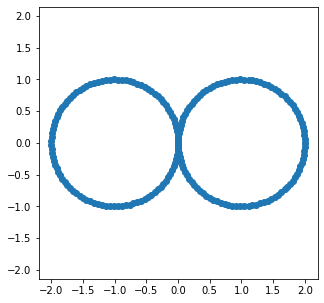

In [168]:
#On discrétise la frontière du double cercle

cercle1 = [(np.cos(theta)+1,np.sin(theta)) for theta in np.linspace(0,2*np.pi,100)]
cercle2 = [(np.cos(theta)-1,np.sin(theta)) for theta in np.linspace(0,2*np.pi,100)]
figure = np.array(cercle1 + cercle2)
plt.scatter(figure[:,0],figure[:,1])
plt.axis('equal')



**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [164]:
#Ici la version finale qui prend en entrée une liste décrivant la ligne de niveau souhaitée 
def area_triangleslist(liste):
    
    #liste = np.array(level_curve(f, x0, y0, delta=delta, N=2000, eps=eps ))
    
    P = (0,0)

    area = 0
    
    def a_triangle(P,Z1,Z2):
        return np.linalg.det(np.array([Z1-P,Z2-P]))/2
    
    for i in range(len(liste)-1) : 
        Z1,Z2 = liste[i],liste[i+1]
        area += a_triangle(P,Z1,Z2)
    
    return area

In [113]:
area_triangleslist(figure) #calcul aire double disque

6.2789680459998936

In [174]:
# En réalité cette méthode ne permet de conrtôler directement c 
#car level curve prend en argument (x0,y0) initiaux. 
#On peut alors proposer la fontion suivante : 

def area_triangles_finale(f,c,delta):
    # retrouver x0, y0 initial sur la frontière pour appliquer level curve
    def finte(x,y):
       x = np.array(x)
       y = np.array(y)
       #définition d'une contrainte x = y
       return np.array([f(x,y)-c,x - y])
    x0,y0 = Newton(finte, 0.1, 0.1)
    
    plt.figure()
    liste = np.array(level_curve(f, x0, y0, delta=delta, N=2000, eps=eps ))
    
    area = 0
    
    P = (0,0) #on a montré que le choix du point importait peu
    
    def a_triangle(P,Z1,Z2):
        return np.linalg.det(np.array([Z1-P,Z2-P]))/2
    
    for i in range(len(liste)-1) : 
        Z1,Z2 = liste[i],liste[i+1]
        area += a_triangle(P,Z1,Z2)
    
    return area

In [ ]:
#Comparaison des temps d'excécution des différentes méthdodes : 

In [192]:
#Temps d'exécution triangle avec pour arguments (f,c,delta) : 

start2 = time.process_time()
area_triangles_finale(f4,1,0.01)
end2 = time.process_time()

print(f"Temps d'exécution avec pour arguments (f,c,delta) : {end2-start2} secondes")

Temps d'exécution avec pour arguments (f,c,delta) : 1.015625 secondes


<Figure size 360x360 with 0 Axes>

In [193]:
#Temps d'exécution triangle avec pour arguments (liste) :

start3 = time.process_time()
area_triangleslist(np.array(level_curve(f4, 1.,0. , delta=0.1, N=2000, eps=eps )))
end3 = time.process_time()

print(f"Temps d'exécution avec pour arguments (liste) : {end3-start3} secondes")

Temps d'exécution avec pour arguments (liste) : 0.40625 secondes


In [ ]:
#C'est plus rapide quand on lui donne la liste mais on ne contrôle pas le niveau c, seulement le point de départ 

In [194]:
#Méthode des carrés : temps d'exécution avec pour arguments (f,c,delta) :

start4 = time.process_time()
area_squares(f4,1,0.01)
end4 = time.process_time()

print(f"Temps d'exécution avec pour arguments (f,c,delta) : {end4-start4} secondes")

<Figure size 360x360 with 0 Axes>

Temps d'exécution avec pour arguments (f,c,delta) : 1.078125 secondes


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

[1.    0.1   0.01  0.001] [8.58407346e-01 1.84073464e-02 1.20734641e-03 6.13464102e-05]


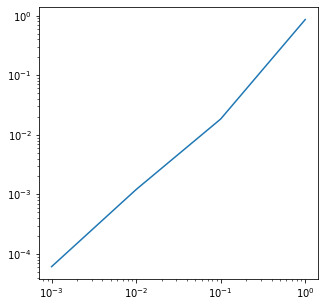

[1.    0.1   0.01  0.001] [5.43516121e-01 5.12578525e-03 5.22010349e-05 1.25666895e+01]


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

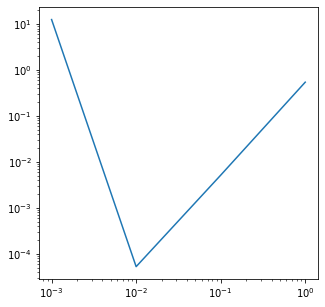

[1.    0.1   0.01  0.001] [5.43516212e-01 3.52484108e-02 1.59257323e-03 1.25666251e+01]


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

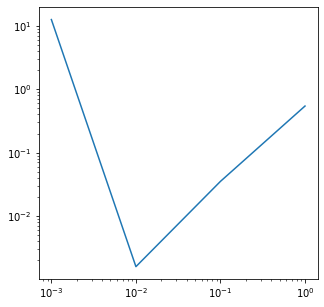

In [195]:
#Comparaison des précisions 
def traceErreur(aire,f,N):
     resul = []
     for i in range(N):
         resul.append(aire(f, 1, 10 ** -i))
     resul = np.array(resul)
     resul = np.abs(resul - np.pi)
     H = np.array([10 ** -i for i in range(N)])
     plt.loglog(H, resul)
     print(H, resul)
     plt.show()

traceErreur(area_squares,f4,4)        
traceErreur(area_triangles,f4,4) #on voit que c'est la plus précise 
traceErreur(area_triangles_finale,f4,4)




In [ ]:
# Il est difficile de comparer les précisions h et delta entre les deux méthodes, 
# on constate cependant que pour obtenir une précision de 10^-4 , avec un delta de 0,01 
# pour les deux méthodes, il faut un h = 0,001 dans la méthode des carrés 

# Néanmoins entre les deux méthodes avec triangles : celle qui calcule P à partir
#d'un vecteur orthogonal au gradient(x0,y0) est au moins 10 fois plus précise qu'avec
#le choix arbitraire de (0,0)